# Proyek Klasifikasi Gambar: Tumor Image
- **Nama:** Yoan Rifqi Candra
- **Email:** yoanrifqicandra@gmail.com
- **ID Dicoding:** Yoan Rifqi Candra

## Import Semua Packages/Library yang Digunakan

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import random
import seaborn as sns
import os
from glob import glob
import shutil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
#import tensorflowjs as tfjs
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout

# Fix for deprecated np.object
np.object = object


## Data Preparation

### Data Loading

In [2]:
data_path = r"C:\Users\Yoan Rifqi\Downloads\Project Analysis Personal\Project Classification Image\Rice_Image_Dataset"
images, labels = [], []

for subfolder in os.listdir(data_path):

  subfolder_path = os.path.join(data_path, subfolder)
  if os.path.isdir(subfolder_path):

    for image_file in os.listdir(subfolder_path):
      image_path = os.path.join(subfolder_path, image_file)
      images.append(image_path)
      labels.append(subfolder)

df = pd.DataFrame({"image_path": images, "label": labels})
df.head()

,image_path,label
0,C:\Users\Yoan Rifqi\Downloads\Project Analysis...,Arborio
1,C:\Users\Yoan Rifqi\Downloads\Project Analysis...,Arborio
2,C:\Users\Yoan Rifqi\Downloads\Project Analysis...,Arborio
3,C:\Users\Yoan Rifqi\Downloads\Project Analysis...,Arborio
4,C:\Users\Yoan Rifqi\Downloads\Project Analysis...,Arborio


In [3]:
img = cv2.imread(df.image_path[0])
img.shape

(250, 250, 3)

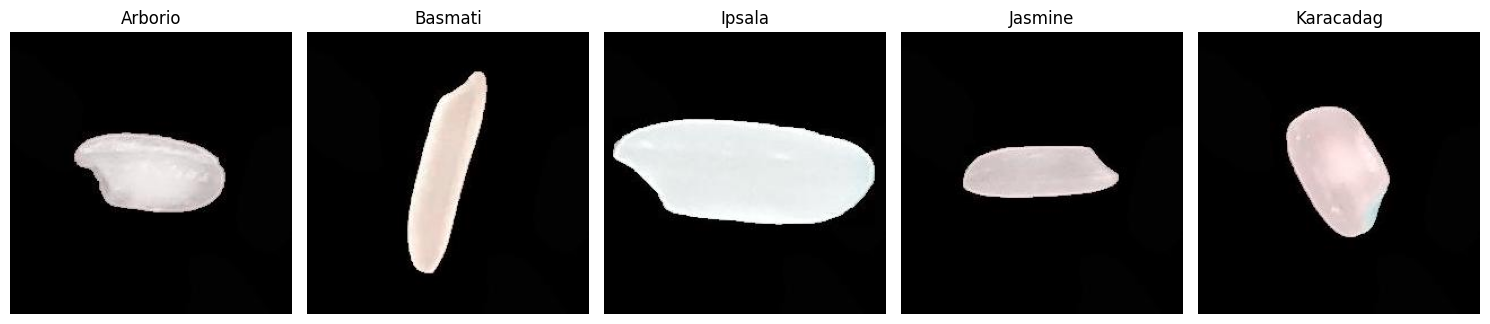

In [4]:
fig, ax = plt.subplots(1,5, figsize=(15,10))
for index, label in enumerate(df.label.unique()):
  img = df[df["label"] == label]["image_path"].iloc[0]
  img = cv2.imread(img)
  ax[index].imshow(img)
  ax[index].set_title(label)
  ax[index].axis("off")

plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

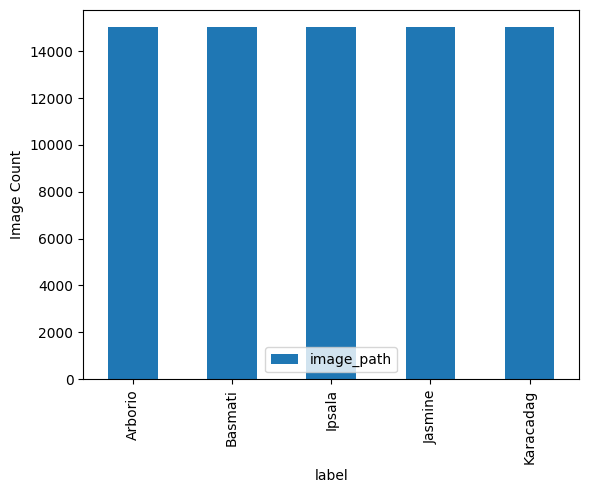

In [5]:
plt.figure(figsize=(10,5))
df.groupby("label").count().plot(kind="bar")
plt.ylabel("Image Count")
plt.show()

In [6]:
# Split 1: Train (70%) dan Temp (30%)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    stratify=df["label"]
)

# Split 2: Temp dipecah menjadi Validation (15%) dan Test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # Setengah dari 30% untuk test, setengah lagi untuk val
    random_state=42,
    stratify=temp_df["label"]
)

print("Original shape :", df.shape)
print("Train shape     :", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape      :", test_df.shape)

Original shape : (75000, 2)
Train shape     : (52500, 2)
Validation shape: (11250, 2)
Test shape      : (11250, 2)


### Data Preprocessing

#### Split Dataset

In [7]:
# Split 1: Train (70%) dan Temp (30%)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    stratify=df["label"]
)

# Split 2: Temp dipecah menjadi Validation (15%) dan Test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # Setengah dari 30% untuk test, setengah lagi untuk val
    random_state=42,
    stratify=temp_df["label"]
)

print("Original shape :", df.shape)
print("Train shape     :", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape      :", test_df.shape)

Original shape : (75000, 2)
Train shape     : (52500, 2)
Validation shape: (11250, 2)
Test shape      : (11250, 2)


In [8]:
# Tambahkan validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Tambahkan ini
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Gunakan subset="training"
train_data_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=256,
    class_mode="categorical",
    subset="training",  # Wajib ada
    shuffle=False
)

val_data_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=256,
    class_mode="categorical",
    subset="validation",  # Wajib ada
    shuffle=False
)

# Tidak perlu ubah bagian test
test_data_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=256,
    class_mode="categorical",
    shuffle=False
)

Found 42000 validated image filenames belonging to 5 classes.
Found 10500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [9]:
train_data_generator.class_indices

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

## Modelling

In [10]:
model = Sequential()

model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64, 64, 3),
                     kernel_regularizer = l1_l2(0.0001, 0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=64,
                      kernel_size=(3, 3),
                      activation='relu',
                      kernel_regularizer = l1_l2(0.0001, 0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,
                      kernel_size=(3, 3),
                      activation='relu',
                      kernel_regularizer = l1_l2(0.0001, 0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(units=256,
                   activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics = ["accuracy"])
#
model.summary()

c:\Users\Yoan Rifqi\Downloads\Project Analysis Personal\Project Classification Image\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,445 (6.61 MB)

 Trainable params: 1,733,061 (6.61 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Hitung class weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data_generator.classes),
    y=train_data_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Training model
history = model.fit(
    train_data_generator,
    epochs=7,
    validation_data=val_data_generator,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

c:\Users\Yoan Rifqi\Downloads\Project Analysis Personal\Project Classification Image\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
165/165 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.4299 - loss: 1.8429 - val_accuracy: 0.1984 - val_loss: 14.8529
Epoch 2/7
165/165 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.8029 - loss: 0.7645 - val_accuracy: 0.2307 - val_loss: 19.6172
Epoch 3/7
165/165 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8979 - loss: 0.5153 - val_accuracy: 0.3347 - val_loss: 6.3065
Epoch 4/7
165/165 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9334 - loss: 0.3940 - val_accuracy: 0.4441 - val_loss: 4.0906
Epoch 5/7
165/165 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9553 - loss: 0.3124 - val_accuracy: 0.9334 - val_loss: 0.3218
Epoch 6/7
165/165 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9579 - loss: 0.2853 - val_accuracy: 0.5630 - val_loss: 1.8838
Epoch 7/7
165/165 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.9618 - loss: 0.2653 - val_accuracy: 0.9639 - val_loss: 0.2234


## Evaluasi dan Visualisasi

### CNN Model Evaluasi dan Visualisasi

In [12]:
# 1. Prediksi data train
train_preds = model.predict(train_data_generator)
train_preds_labels = np.argmax(train_preds, axis=1)

# 2. Prediksi data test
test_preds = model.predict(test_data_generator)
test_preds_labels = np.argmax(test_preds, axis=1)

# 3. True label
true_train_labels = train_data_generator.classes
true_test_labels = test_data_generator.classes

# 4. Classification Report - Train
print("Classification Report - Train Data")
print(classification_report(true_train_labels, train_preds_labels, target_names=list(train_data_generator.class_indices.keys())))

# 5. Classification Report - Test
print("Classification Report - Test Data")
print(classification_report(true_test_labels, test_preds_labels, target_names=list(test_data_generator.class_indices.keys())))

165/165 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 657ms/step
Classification Report - Train Data
              precision    recall  f1-score   support

     Arborio       0.98      0.94      0.96      8399
     Basmati       0.92      1.00      0.96      8413
      Ipsala       1.00      1.00      1.00      8347
     Jasmine       0.98      0.90      0.94      8422
   Karacadag       0.95      0.99      0.97      8419

    accuracy                           0.97     42000
   macro avg       0.97      0.97      0.97     42000
weighted avg       0.97      0.97      0.97     42000

Classification Report - Test Data
              precision    recall  f1-score   support

     Arborio       0.89      1.00      0.94      2250
     Basmati       0.94      1.00      0.97      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       1.00      0.83      0.90      2250
   Karacadag       1.00      0.98      0.99      2250

    accuracy                    

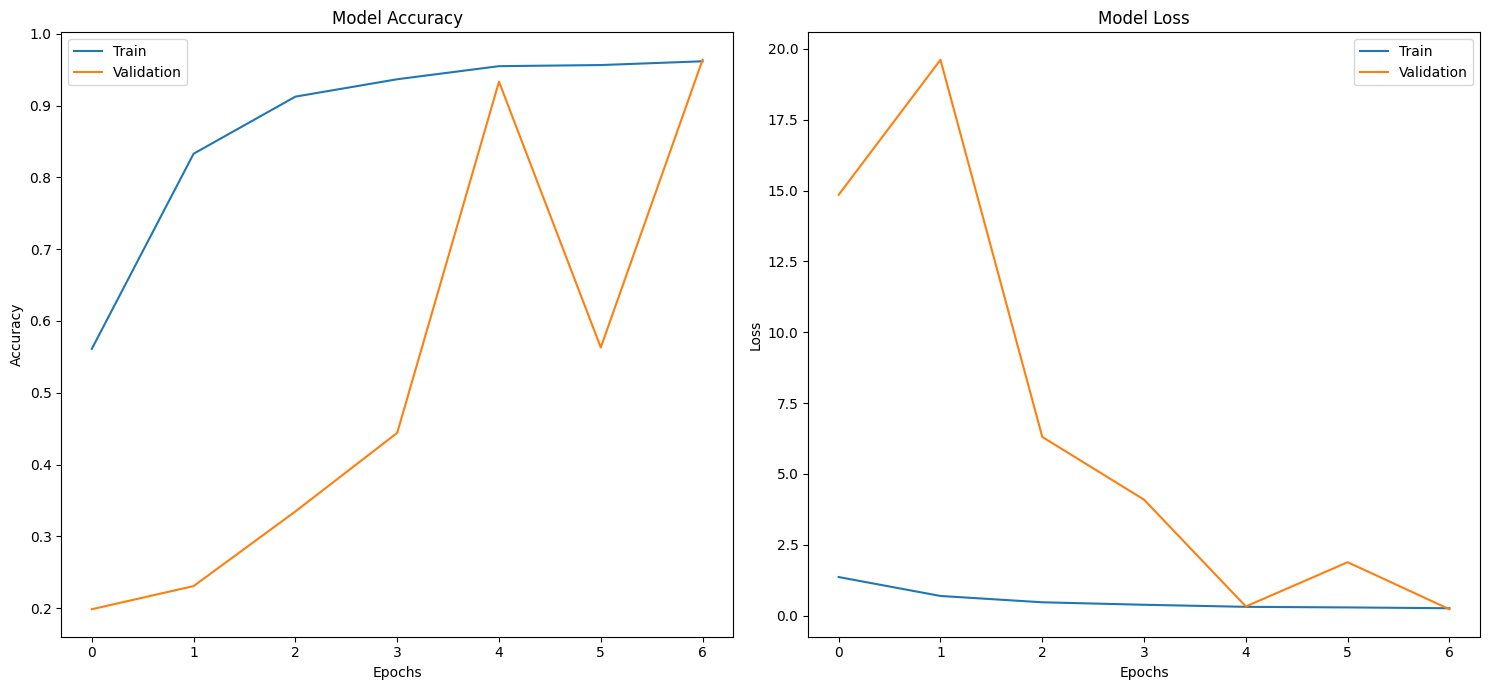

In [13]:
# Plot accuracy & loss
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot akurasi
ax[0].plot(history.history["accuracy"], label="Train")
ax[0].plot(history.history["val_accuracy"], label="Validation")
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Plot loss
ax[1].plot(history.history["loss"], label="Train")
ax[1].plot(history.history["val_loss"], label="Validation")
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [ ]:
from tensorflow.keras.models import load_model

model.export("saved_model")

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    model_rice.h5 \
    model_tfjs

In [ ]:
# Load model dari file .h5
model = load_model("model_rice.h5")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model ke file .tflite
with tf.io.gfile.GFile('model_rice.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label ke label.txt sesuai urutan indeks
class_indices = {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
sorted_labels = sorted(class_indices.items(), key=lambda x: x[1])
with open('label.txt', 'w') as f:
    for label, _ in sorted_labels:
        f.write(f"{label}\n")